# <center> R4.04 Méthodes d'optimisation <br> TP3b - Interpolation polynomiale : le partage de secret </center>
<center> 2023/2024 - Tom Ferragut, Thibault Godin & Lucie Naert </center>
<center> IUT de Vannes, BUT Informatique </center>

Le but de ce TP est de présenter deux applications de l'interpolation polynôminale : le _partage de secret de Shamir_ et un exemple jouet de protocole de _correction d'erreurs_.

In [2]:
import itertools
import random
import time

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from mpl_toolkits.mplot3d import Axes3D 

# Affichage graphique
# %matplotlib notebook 
# enable interactivity of plots
# attention a bien fermer les fenetres plt après chaque visualisalgèbreation
%matplotlib inline
names_col = list(mcolors.XKCD_COLORS)


On rappelle le théorème central de l'interpolation :  

<div class="alert alert-block alert-info"><b>Théorème</b>

Soient $n$ points $(x_1,y_1), ..., (x_n,y_n)$ de $\mathbb{R}^2$  
Alors il existe un unique polynôme $P_{(x_1,y_1), ..., (x_n,y_n)}$ de degré inférieur ou égal à $n-1$  tel que $P_{(x_1,y_1), ..., (x_n,y_n)}(x_i) = y_i$

</div>

Les fonctions suivantes permettent de faire une interpolation polynomiale par la méthode de Lagrange (voir TP3a). Plus précisément, à partir des coordonnées `X` et `Y` des noeuds d'interpolation, `pol_Lagrange(varX,X,Y)` calcule le polynome $P$ passant par tout les noeuds d'interpolation et renvoie $P(varX)$.


In [3]:
def pol_li(varX,i,X,Y):
    li=1
    for j in range(len(X)):
        if i!=j:
            li=li*((varX-X[j])/(X[i]-X[j]))
    return Y[i]*li


def pol_Lagrange(varX,X,Y):
    l=0
    for i in range(len(X)):
        l=l+pol_li(varX,i,X,Y)
        
    return np.round(l)


## Partage de secret : protocole de Shamir

Contexte :  
supposons qu'on veuille distribuer un secret $S$ (un nombre) à $m$ personnes $p_1, ..., p_m$  
Le but est que
- $n$ personnes (ou plus) peuvent connaître facilement le secret ($n\leq m$)
- $n-1$ personnes (ou moins) ne peuvent pas le découvrir (facilement)

L'approche par du Shamir Secret Sharing (SSS)  (simplifiée) est alors :
- partage :
    - créer un polynôme $P$ de degré $n-1$ tel que $P(0)=S$ en tirant aléatoirement $n-1$ valeurs pour les $P(-k), k \in \{1,2,...,n-1\}$
    - attribuer à chaque personne $p_i$, $i \in \{1,2,...,m\}$, la valeur $s_i=P(i)$
- reconstruction :
    - si $n$ personne $p_{i_1}, ..., p_{i_n}$ créent le polynôme $Q$ interpolant $(i_1,s_{i_1}), ..., (i_n,s_{i_n})$, alors $Q=P$ et donc l'évaluation de ce polynôme en $0$ donne $S$

Les  $s_i$ sont appelés les sous-secrets.


Remarques :
- La version [Wikipedia](https://fr.wikipedia.org/wiki/Partage_de_cl%C3%A9_secr%C3%A8te_de_Shamir) est un peu différente (mais pas plus compliquée) : on choisit au hasard les coefficients du polynome et non des points par lequel passe le polynome.
- Si k personnes se regroupent (k > n), le secret pourra quand même être retrouvé car il existe un unique polynome de degrès inf ou égal à k-1 passant par les k points : ce degrés est donc n-1.


**Question 1**
1. Écrire une fonction `partage(S,m,n)` avec $S$ le secret (un nombre), $m$ le nombre de personnes partageant le secret et $n$ le nombre de personnes nécessaires à la reconstruction du secret. Cette fonction renvoie la liste des $s_i$ pour $i$ allant de $1$ à $m$ ainsi que $X$ (vecteurs des absisses des noeuds d'interpolation) et $Y$ (vecteurs des ordonnées des noeuds d'interpolation). Attention : $X$ et $Y$ n'ont d'intérêts que pour la représentation graphique, ils ne devront pas être utilisés pour la reconstruction.
2. Remplir la légende du graphique


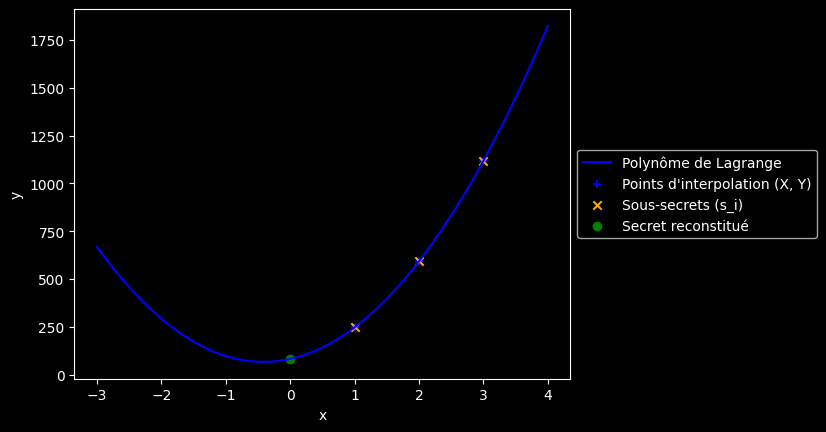

Voici les sous-secrets à partager :  [248, 593, 1118]
Ainsi, la personne 1 recevra le sous secret 248


In [4]:
def partage(S, n, m):
    coefficients = [S] + [random.randint(1, 100) for _ in range(n - 1)]


    def P(x):
        return sum([coefficients[k] * x**k for k in range(n)])


    X = np.arange(1, m + 1)
    Y = [P(xi) for xi in X]
    si = Y.copy()

    return X, Y, si

# Application
# Secret
S = 83
# Nombre de personnes partageant le secret
m = 3
# Nombre de personnes nécessaires à la reconstruction
n = 3
X, Y, si = partage(S, n, m)

# Représentation graphique
tab_x = np.linspace(-n, m + 1, 500)
tab_yLagrange = pol_Lagrange(tab_x, X, Y)
pi = np.arange(1, m + 1)
plt.plot(tab_x, tab_yLagrange, color='blue', label="Polynôme de Lagrange")
plt.scatter(X, Y, color='blue', marker='+', label="Points d'interpolation (X, Y)")
plt.scatter(pi, si, color='orange', marker='x', label="Sous-secrets (s_i)")
plt.scatter(0, pol_Lagrange(0, X, Y), color='green', marker='o', label="Secret reconstitué")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.ylim(-1000, 1000)  # pour voir les détails des points pris au hasard
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print("Voici les sous-secrets à partager : ", si)
print("Ainsi, la personne 1 recevra le sous secret", si[0])


**question 2**
1. Écrire une fonction `reconstruction(k,sk)` permettant de retrouver le secret. `k` est la liste des indices des personnes se rassemblant pour partager leur sous-secret ($k \subset \{1,2,...,m\}$). `sk` est la liste des sous-secrets (de même taille que `k`).
2. Montrez que vous arrivez à retrouver le secret $S$ quand on a $n$ (ou plus) sous-secrets mais pas quand on en a moins.


In [6]:
def reconstruction(k, sk):
    def pol_li(varX, i, k, sk):
        li = 1
        for j in range(len(k)):
            if i != j:
                li = li * ((varX - k[j]) / (k[i] - k[j]))
        return sk[i] * li


    def pol_Lagrange(varX, k, sk):
        l = 0
        for i in range(len(k)):
            l = l + pol_li(varX, i, k, sk)
        return np.round(l)
    
    return pol_Lagrange(0, k, sk)


S = 55
m = 3
n = 3
_, _, si = partage(S, n, m)

# Test avec n sous-secrets
k = [1, 3, 4, 5, 9]  # Choix d'indices entre 1 et m
# Vérifier que tous les indices de k sont valides
k = [i for i in k if 1 <= i <= m]
sk = [si[x - 1] for x in k]  # Décalage des indices car numérotation python
print("Avec", len(k), "sous-secrets, le secret trouvé est", reconstruction(k, sk))

# Test avec moins de n sous-secrets
k = [1, 3, 4]  # Moins de n indices
# Vérifier que tous les indices de k sont valides
k = [i for i in k if 1 <= i <= m]
sk = [si[x - 1] for x in k]
print("Avec", len(k), "sous-secrets, le secret trouvé est", reconstruction(k, sk))


Avec 2 sous-secrets, le secret trouvé est -5.0
Avec 2 sous-secrets, le secret trouvé est -5.0


**activité**  
À l'aide de ce protocole, partager un secret à 6 de vos camarades de manières à ce qu'il faille au moins 3 d'entre-eux pour le reconstruire.

----


## Suréchantillonage et introduction aux codes de Reed-Solomon

Le but de cette partie est de vous donner un protocole de correction d'erreur qui peut-être vu comme une (grosse) simplification des codes de Reed-Solomon.  
Le principe est le suivant :  
On veut transmettre un message de $k$ lettres (nombres entiers) $m_0,...,m_{k-1} $ sur un canal bruité.  
Pour cela, on va transmettre les $k$ lettres plus $t$ lettres supplémentaires $r_0,...,r_{t-1}$, construites comme suit :
- on calcule le polynôme d'interpolation $P=P_{(0,m_0),...,(k-1,m_{k-1})}$
- $r_i = P(k+i)$

On transmet le vecteur $[m_0,...,m_{k-1},r_0,...,r_{t-1}]$


**question 3**
1. Écrire une fonction `lettreSup(t,xm,m)` calculant `r` les $t$ lettres supplémentaires ainsi que `xr` leur indice (les $t$ abscisses des lettres supplémentaires).
2. Compléter la légende de la représentation graphique


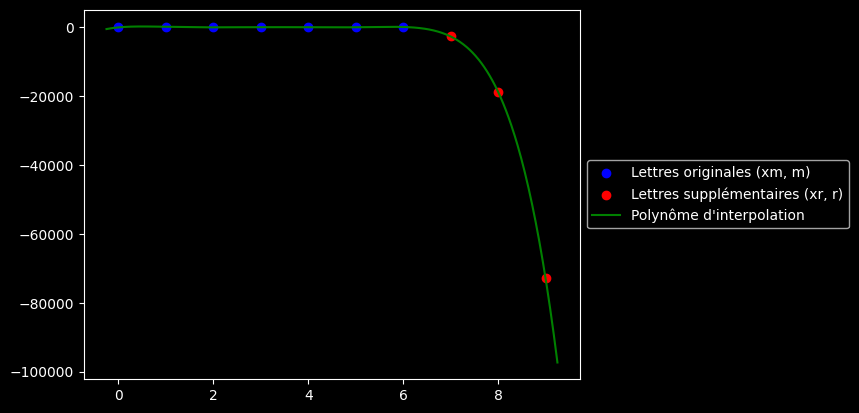

In [7]:
def lettreSup(t, xm, m):
    xr = np.arange(len(xm), len(xm) + t)
    r = [pol_Lagrange(x, xm, m) for x in xr]
    
    return xr, r


k = 7
t = 3
xm = np.arange(k) 
m = random.sample(range(-100, 100), k)
xr,r = lettreSup(t, xm, m)
# tracé
plt.scatter(xm,m, color = 'blue', label = "Lettres originales (xm, m)")
plt.scatter(xr,r, color = 'red', label = "Lettres supplémentaires (xr, r)")
xcont = np.linspace(-.25, k + t - 0.75, 500)
plt.plot(xcont, pol_Lagrange(xcont, xm, m), color = 'green', label = "Polynôme d'interpolation")
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.show()


La détection d'erreur se fait en évaluant tous les polynômes $Q_S$ interpolant un sous-ensemble $S$ de taille $k$ : $S \subset \{(0,m_0),...,(k-1,m_{k-1}),(k,r_0),...,(k+t-1,r_{t-1})\}$  
Si toutes les valeurs $Q_s(i) , i \in \{0,...,k+t-1\}$ s'accordent, alors il n'y a (très très probablement) pas d'erreur.  

**question 4**
1. Écrire une fonction `detectErreur(k,yt)` où k est le nombre de lettres du message et `yt` est la liste complète des lettres ($[m_0,...,m_{k-1},r_0,...,r_{t-1}]$). Cette fonction renvoie `True` s'il y a une erreur dans le message et `False` s'il n'y a (très très probablement) pas d'erreur.  
_Astuce python_ : on pourra utiliser `list_s= list(itertools.combinations(...))` pour construire les sous-ensembles.
2. Compléter la légende de la représentation graphique


In [9]:
def detectErreur(k, yt):
    n = len(yt)
    xt = np.arange(n)
    list_s = list(itertools.combinations(xt, k))
    
    for s in list_s:
        s = list(s)
        Q_s = [pol_Lagrange(i, s, yt[s]) for i in xt]
        if np.allclose(Q_s, yt):
            return False
    return True


k = 7
t = 3
xm = np.arange(k)
m = random.sample(range(-10, 10), k)
_, r = lettreSup(t, xm, m)
yt = m + r
yt = np.asarray(yt)

print("Erreur de transmission :", detectErreur(k, yt))

# Rajout d'erreurs
yError = yt.copy()
yError[1] = 0
yError[4] = 0 
print("Erreur de transmission :", detectErreur(k, yError))


Erreur de transmission : False
Erreur de transmission : True


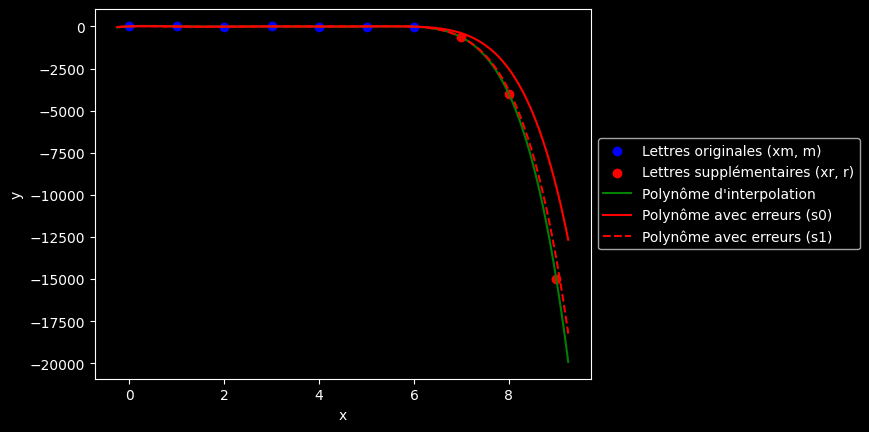

In [10]:
# Représentation graphique
xcont = np.linspace(-.25, len(yt) - 0.75, 500)
plt.scatter(xm, m, color = 'blue', label = "Lettres originales (xm, m)")
plt.scatter(xr, r, color = 'red', label = "Lettres supplémentaires (xr, r)")
plt.plot(xcont, pol_Lagrange(xcont, xm, m), color = 'green', label = "Polynôme d'interpolation")

error = detectErreur(k, yError)
if error:
    xt = np.arange(len(yt))
    list_s = list(itertools.combinations(xt, k))
    s0 = list(list_s[0])
    s1 = list(list_s[4])
    plt.plot(xcont, pol_Lagrange(xcont, s0, yError[s0]), color = 'red', label = "Polynôme avec erreurs (s0)")
    plt.plot(xcont, pol_Lagrange(xcont, s1, yError[s1]), color = 'red', linestyle = '--', label = "Polynôme avec erreurs (s1)")

plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.xlabel('x')
plt.ylabel('y')
plt.show()


La correction d'erreurs est plus subtile.  

**question 5**  
Observer ce qui se passe quand on a 1 erreur de transmission. Proposer une fonction de correction en cas d'erreur  
_python_ on pourra utiliser `sub= list(itertools.combinations(...))` pour construire les sous-ensembles et `from collections import Counter` pour compter les valeurs


In [13]:
def correctErreur(k, yt):
    n = len(yt)
    xt = np.arange(n)
    list_s = list(itertools.combinations(xt, k))
    interpolated_values = [[] for _ in range(n)]
    for s in list_s:
        s = list(s)
        Q_s = [pol_Lagrange(i, s, yt[s]) for i in xt]
        for i in range(n):
            interpolated_values[i].append(Q_s[i])

    corrected_values = []
    for values in interpolated_values:
        most_common = Counter(values).most_common(1)[0][0]
        corrected_values.append(most_common)

    return np.array(corrected_values)


k = 7
t = 3
xm = np.arange(k)
m = random.sample(range(-100, 100), k)
_, r = lettreSup(t, xm, m)
yt = m + r
yt = np.asarray(yt)

# Corriger sans erreur
print("Message initial : ", yt)
print("\nMessage corrigé (sans erreur) : ", correctErreur(k, yt))

# Rajout d'erreurs
yError = yt.copy()
yError[1] = 0
print("\nMessage avec erreur :", yError)
print("\nMessage corrigé : ", correctErreur(k, yError))


Message initial :  [-8.80000e+01 -2.90000e+01  0.00000e+00 -9.80000e+01  2.00000e+01
 -9.20000e+01 -6.40000e+01  5.72900e+03  3.54400e+04  1.29857e+05]

Message corrigé (sans erreur) :  [-8.80000e+01 -2.90000e+01  0.00000e+00 -9.80000e+01  2.00000e+01
 -9.20000e+01 -6.40000e+01  5.72900e+03  3.54400e+04  1.29857e+05]

Message avec erreur : [-8.80000e+01  0.00000e+00  0.00000e+00 -9.80000e+01  2.00000e+01
 -9.20000e+01 -6.40000e+01  5.72900e+03  3.54400e+04  1.29857e+05]

Message corrigé :  [-8.80000e+01  0.00000e+00  0.00000e+00 -9.80000e+01  2.00000e+01
 -9.20000e+01 -6.40000e+01  5.72900e+03  3.54400e+04  1.29857e+05]
